In [1]:
import numpy as np
from scipy import optimize
import healpy as hp
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u 
from scipy.stats import norm
from joblib import Parallel, delayed
from scipy import interpolate
from scipy.integrate import simps
import arviz as az
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import pi

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
                  (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
                  (255, 188, 121), (207, 207, 207)]

# Rescale to values between 0 and 1
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
def plt_style():
    plt.rcParams.update({
    'lines.linewidth':1.0,
    'lines.linestyle':'-',
    'lines.color':'black',
    'font.family':'serif',
    'font.weight':'normal',
    'font.size':16.0,
    'text.color':'black',
    'text.usetex':True,
    'axes.edgecolor':'black',
    'axes.linewidth':1.0,
    'axes.grid':False,
    'axes.titlesize':'large',
    'axes.labelsize':'large',
    'axes.labelweight':'normal',
    'axes.labelcolor':'black',
    'axes.formatter.limits':[-4,4],
    'xtick.major.size':7,
    'xtick.minor.size':4,
    'xtick.major.pad':8,
    'xtick.minor.pad':8,
    'xtick.labelsize':'large',
    'xtick.minor.width':1.0,
    'xtick.major.width':1.0,
    'ytick.major.size':7,
    'ytick.minor.size':4,
    'ytick.major.pad':8,
    'ytick.minor.pad':8,
    'ytick.labelsize':'large',
    'ytick.minor.width':1.0,
    'ytick.major.width':1.0,
    'legend.numpoints':1,
    'legend.fontsize':'large',
    'legend.shadow':False,
    'legend.frameon':False})
    

def lnlike(s_arr,b_arr,lam,f):
    return np.sum(np.log(lam*s_arr+b_arr))-f*lam

def gauss(mu_gauss, std_gauss, x_value):
    return np.exp(-(x_value-mu_gauss)*(x_value-mu_gauss)/(2*std_gauss*std_gauss))/(std_gauss*(2.*pi)**0.5)

#f=1 in the limit where we detect all AGNs flares
f=1.
lam=0.7
H0=70.
omegam=0.3
mapname='GW190521_NRSurPHM_skymap_moresamples_1024.fits.gz'
z_min_b = 0.01 #Minimum z for background events
z_max_b = 1.
mpi=False
lam_arr=np.linspace(0,1.,num=100)

N_followup_samples=100
N_GW_followups=40
#Expected number of signal and back events for Poissoin distr
B_expected_n= 1e-4*34000. 
njobs=40
cosmo = FlatLambdaCDM(H0=H0, Om0=omegam)

hs=fits.open(mapname)[1]
pb = hs.data['PROB']
distnorm= hs.data['DISTNORM']
distmu= hs.data['DISTMU']
distsigma= hs.data['DISTSIGMA']
NSIDE = hs.header['NSIDE']
pixarea = hp.nside2pixarea(NSIDE, degrees=True)
#hpixs=np.range(hp.nside2npix(NSIDE)) 
pb_frac = 0.90
idx_sort = np.argsort(pb)
idx_sort_up = list(reversed(idx_sort))
sum = 0.
id = 0
while sum<pb_frac:
    this_idx = idx_sort_up[id]
    sum = sum+pb[this_idx]
    id = id+1

idx_sort_cut = idx_sort_up[:id]


def followup_sample(k,lamb,N_GW_followups):
    S_expected_n=1.*lamb
    print("Follow-up sample n ",k)
    lnlike_arr= np.zeros((N_GW_followups,lam_arr.shape[0]))
    #These are all arrays w/ 1 entry per follow-up
    #make sure these are integers!
    S_cands= np.random.poisson(S_expected_n,N_GW_followups)
    B_cands= np.random.poisson(B_expected_n,N_GW_followups)
    N_cands= S_cands+B_cands
    
    maxdist = cosmo.luminosity_distance(z_max_b)
    ds_arr_norm=np.linspace(0,maxdist.value,num=1000)
    
    for i in range(N_GW_followups):
        Ncand = N_cands[i]
        #Now get positions and redshifts for the signal candidates
        s_hpixs=np.random.choice(idx_sort_cut, p=pb[idx_sort_cut]/pb[idx_sort_cut].sum(),size=S_cands[i])
        s_zs=[]
        for j in range(S_cands[i]):
            #Added in a dist**2 here for the posterior along los...but maybe we only want the likelihood?
            #prob_los=gauss(distmu[s_hpixs[j]],distsigma[s_hpixs[j]], ds_arr_norm)*ds_arr_norm**2
            #s_ds=np.random.choice(ds_arr_norm, p=prob_los/prob_los.sum())
            #print(prob_los)
            s_ds=np.random.normal(loc=distmu[s_hpixs[j]], scale=distsigma[s_hpixs[j]])
            while (s_ds<0):
                s_ds=np.random.normal(loc=distmu[s_hpixs[j]], scale=distsigma[s_hpixs[j]])
            s_zs.append(z_at_value(cosmo.luminosity_distance, s_ds * u.Mpc,zmin=0.00,zmax=5.) )
        #Now get positions and redshifts for the background candidates   
        #Let's assume they are just uniform in comoving volume between z_min and z_max
        s_zs=np.array(s_zs)
        b_hpixs=np.random.choice(idx_sort_cut, size=B_cands[i])
        zs_arr=np.linspace(z_min_b,z_max_b,num=1000)
        zs2=zs_arr**2
        b_zs=np.random.choice(zs_arr, p=zs2/zs2.sum(), size=B_cands[i])
        
        #Positions and z for All candidates in this follow up
        cand_hpixs=np.concatenate((s_hpixs,b_hpixs))
        cand_zs=np.concatenate((s_zs,b_zs))
        cand_ds=np.zeros(cand_zs.shape[0])
        for l in range(cand_zs.shape[0]):
            cand_ds[l]=cosmo.luminosity_distance(cand_zs[l]).value
        
        #s_arr = pb[cand_hpixs] * distnorm[cand_hpixs] * norm(distmu[cand_hpixs], distsigma[cand_hpixs]).pdf(cand_ds) / pixarea
        s_arr = pb[cand_hpixs] * distnorm[cand_hpixs] * norm(distmu[cand_hpixs], distsigma[cand_hpixs]).pdf(cand_ds) * cand_ds**2
        
        
        # The spatial pb for background is 1./npixels in 90%, and divided by pixarea?
        #I think this needs to be properly renormalized....
        #zs_arr_norm=np.linspace(0,10.,num=1000)
        #normaliz = np.trapz(zs2,zs_arr_norm)
        #b_arr = cand_zs**2/normaliz/len(idx_sort_cut) #/pixarea 

        normaliz = np.trapz(ds_arr_norm**2,ds_arr_norm)
        b_arr = cand_ds**2/normaliz/len(idx_sort_cut)
        
        #Check there are canidates at all
        if (s_arr.shape[0])>0:

            #lnlike_arr.append(lnlike(s_arr,b_arr,lam_arr,f))
            for m in range(lam_arr.shape[0]):
                lnlike_arr[i,m]=lnlike(s_arr,b_arr,lam_arr[m],f)
            
        else:
            #I think we need to do something different here, maybe s_arr needs to be set to 0
            print("s_arr empty") 
    
    #np.savetxt('out/lnlike_'+str(lamb)+'_'+str(k)+'.dat',Delta_lnlike)

    return lnlike_arr
    

In [2]:
if mpi:
    lnlikelihood = Parallel(n_jobs=njobs)(delayed(followup_sample)(k,lam) for k in range(N_followup_samples))
else:
    lnlikelihood=[]
    for k in range(N_followup_samples):
        lnlikelihood.append(followup_sample(k,lam,N_GW_followups))
    
    
#np.savetxt('lnlike_lambda_GW190521_100.dat',lnlikelihood)

Follow-up sample n  0
Follow-up sample n  1
s_arr empty
Follow-up sample n  2
s_arr empty
Follow-up sample n  3
s_arr empty
Follow-up sample n  4
s_arr empty
s_arr empty
Follow-up sample n  5
s_arr empty
Follow-up sample n  6
s_arr empty
Follow-up sample n  7
Follow-up sample n  8
s_arr empty
Follow-up sample n  9
s_arr empty
Follow-up sample n  10
Follow-up sample n  11
Follow-up sample n  12
s_arr empty
Follow-up sample n  13
Follow-up sample n  14
s_arr empty
s_arr empty
Follow-up sample n  15
Follow-up sample n  16
Follow-up sample n  17
Follow-up sample n  18
Follow-up sample n  19
Follow-up sample n  20
s_arr empty
Follow-up sample n  21
Follow-up sample n  22
Follow-up sample n  23
s_arr empty
Follow-up sample n  24
Follow-up sample n  25
Follow-up sample n  26
s_arr empty
s_arr empty
Follow-up sample n  27
s_arr empty
Follow-up sample n  28
Follow-up sample n  29
s_arr empty
Follow-up sample n  30
s_arr empty
s_arr empty
Follow-up sample n  31
Follow-up sample n  32
s_arr empty

0.696969696969697


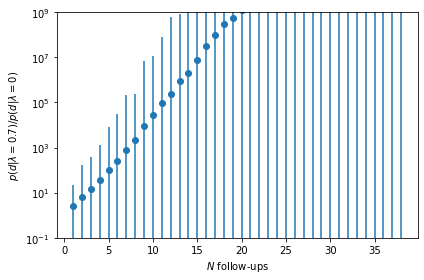

In [239]:
#Try Bayes factors

Nfollowups_plot=np.arange(1,39)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

bestidx_lam=find_nearest(lam_arr,lam)
print(lam_arr[bestidx_lam])


for j in Nfollowups_plot:
    bayes_f=[]
    for k in range(N_followup_samples):
        #fixes very low exp values - otherwise the likelihood is always 0. lnlike initially not properly normalized.
        
        lnlikesum=np.sum(lnlikelihood[k][:j,:],axis=0)
        fixer=lnlikesum[0]
        like=np.exp(lnlikesum-fixer)
        norm=np.trapz(like,lam_arr)
        like=like/norm
              
        if np.isinf(like[bestidx_lam]/like[0]):
            print("factor inf")
            bayes_f.append(1e9)
        else:
            bayes_f.append(like[bestidx_lam]/like[0])
            
    plt.errorbar(j,np.median(bayes_f),yerr=np.std(bayes_f),color=tableau20[0],fmt='o')
    #plt.scatter(j,np.median(bayes_f),color=tableau20[0])
    #print(bayes_f)
    

plt.xlabel('$N$ follow-ups')
plt.ylabel(r'$p(d|\lambda=$'+str(lam)+'$)/p(d|\lambda=0)$')
plt.yscale('log')
plt.ylim(0.1,1e9)
plt.tight_layout()
plt.savefig('bayes_factor_to_0.png',dpi=200)

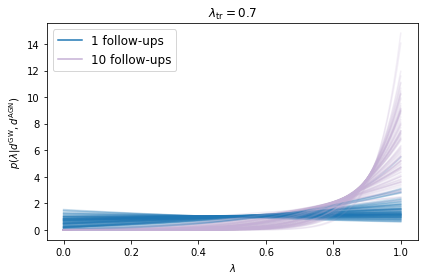

In [3]:
Nfollowups_plot=[1,10]
#plt_style()

for k in range(100): #N_followup_samples):
    for j in Nfollowups_plot:
        #fixes very low exp values - otherwise the likelihood is always 0. lnlike initially not properly normalized.
        #fixer=50.*j 
        #like=np.sum(lnlikelihood[k][:j,:],axis=0)+fixer
        #norm=np.trapz(np.exp(like),lam_arr)
        lnlikesum=np.sum(lnlikelihood[k][:j,:],axis=0)
        fixer=lnlikesum[0]
        like=np.exp(lnlikesum-fixer)
        norm=np.trapz(like,lam_arr)
        if norm==0: print(lnlikelihood[k][:j,:])
        plt.plot(lam_arr,like/norm,alpha=0.2,color=tableau20[j-1])
        
for j in Nfollowups_plot:
    plt.plot([0,0],[0,0],color=tableau20[j-1],label=str(j)+' follow-ups')
        
        
plt.xlabel('$\lambda$')
plt.ylabel(r'$p(\lambda|d^{\rm GW},d^{\rm AGN})$')
plt.legend(fontsize=12)
plt.title(r'$\lambda_{\rm tr}=$'+str(lam))
plt.tight_layout()
plt.savefig('lam_'+str(lam)+'post_1_10.png',dpi=200)

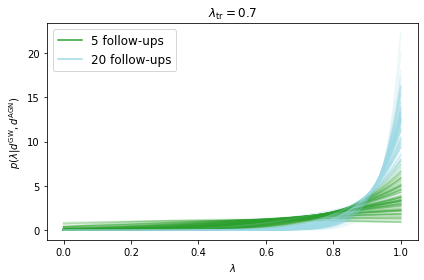

In [235]:
Nfollowups_plot=[5,20]
#plt_style()

for k in range(100): #N_followup_samples):
    for j in Nfollowups_plot:
        #fixes very low exp values - otherwise the likelihood is always 0. lnlike initially not properly normalized.
        lnlikesum=np.sum(lnlikelihood[k][:j,:],axis=0)
        fixer=lnlikesum[0]
        like=np.exp(lnlikesum-fixer)
        norm=np.trapz(like,lam_arr)
        if norm==0: print(lnlikelihood[k][:j,:])
        plt.plot(lam_arr,like/norm,alpha=0.2,color=tableau20[j-1])
        
for j in Nfollowups_plot:
    plt.plot([0,0],[0,0],color=tableau20[j-1],label=str(j)+' follow-ups')
        
#plt.xlim(0,0.2)  
#plt.ylim(0,2)
plt.xlabel('$\lambda$')
plt.ylabel(r'$p(\lambda|d^{\rm GW},d^{\rm AGN})$')
plt.legend(fontsize=12)
plt.title(r'$\lambda_{\rm tr}=$'+str(lam))
plt.tight_layout()
plt.savefig('lam_'+str(lam)+'post_5_20.png',dpi=200)

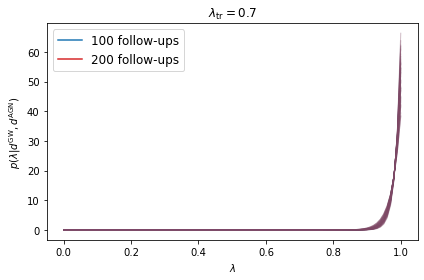

In [236]:
Nfollowups_plot=[100,200]
#plt_style()

for k in range(40): #N_followup_samples):
    for j in Nfollowups_plot:
        #fixes very low exp values - otherwise the likelihood is always 0. lnlike initially not properly normalized.
        lnlikesum=np.sum(np.array(lnlikelihood)[:j,k,:],axis=0)
        fixer=lnlikesum[0]
        like=np.exp(lnlikesum-fixer)
        norm=np.trapz(like,lam_arr)
        #if norm==0: print(lnlikelihood[:j,k,:])
        #print(int(j/100.))
        if j==np.min(Nfollowups_plot): 
            color=0
            alpha=0.2
            lw=1
        else: 
            color=6
            alpha=0.2
        plt.plot(lam_arr,like/norm,alpha=alpha,lw=lw,color=tableau20[color])
        
for j in Nfollowups_plot:
    if j==np.min(Nfollowups_plot): color=0
    else: color=6
    plt.plot([0,0],[0,0],color=tableau20[color],label=str(j)+' follow-ups')
        
        
plt.xlabel('$\lambda$')
plt.ylabel(r'$p(\lambda|d^{\rm GW},d^{\rm AGN})$')
plt.legend(fontsize=12)
plt.title(r'$\lambda_{\rm tr}=$'+str(lam))
plt.tight_layout()
plt.savefig('lam_'+str(lam)+'post_100.png',dpi=200)

In [144]:
Nfollowups_plot=np.arange(1,21)

for j in Nfollowups_plot:
    peak, err99_lo, err99_hi=[],[],[]
    for k in range(N_followup_samples):
        #fixes very low exp values - otherwise the likelihood is always 0. lnlike initially not properly normalized.
        fixer=50.*j 
        like=np.exp(np.sum(lnlikelihood[k][:j,:],axis=0)+fixer)
        norm=np.trapz(like,lam_arr)
        out=cl_around_mode_to_0(lam_arr,like/norm)
        samples = np.random.choice(lam_arr,p=like/like.sum(), size=10000)
        pdf_lo,pdf_hi = az.hdi(samples, hdi_prob=0.9973)
        peak.append(out[1])
        err99_lo.append(pdf_lo)
        err99_hi.append(pdf_hi)
    err99_lo=np.array(peak)-np.array(err99_lo)
    err99_hi=np.array(err99_hi)-np.array(peak)
    plt.errorbar(j,np.mean(peak), yerr=np.array([[err99_lo.mean(),err99_hi.mean()]]).T,color=tableau20[0],fmt='o')
        
plt.xlabel('$N$ follow-ups')
plt.ylabel('$\lambda$')

0.64997997997998

In [135]:
Nfollowups_plot

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

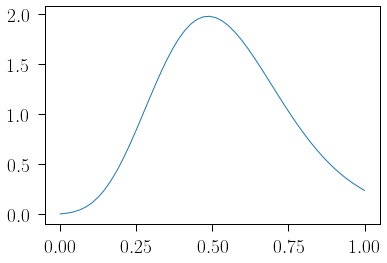

In [122]:
myedg,mypr=lam_arr,np.exp(like)/norm
nbins=1000
edg=np.linspace(0.,1.,num=nbins)
interp=interpolate.interp1d(myedg, mypr,fill_value="extrapolate")
myprob=interp(edg)

peak = edg[np.argmax(myprob)]
idx_sort_up=np.argsort(myprob)#[::-1]
#print(idx_sort_up)
plt.plot(edg,myprob)